# Behavioral Cloning Project

## Libraries

In [1]:
import os
import csv
import cv2
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Lambda, Flatten, Dense, Convolution2D
from keras.models import load_model
from keras import callbacks
from keras.optimizers import Adam

Using TensorFlow backend.


## Constants

In [2]:
# Correction to apply for left and right camera images to simulate additonal data
correction = 0.25

# Range of pixels to translate the image
trans_range = 20

Load different datasets

In [3]:
#dataLocation = './data/Udacity/'
#dataLocation = './data/MyData/'
dataLocation = './data/Track2/'

Udacity data appears to be recorded on a linux machine wheras I am running windows. The directory separaters are opposite each other

In [4]:
#directorySplitter = '/'
directorySplitter = '\\'

## Load Training Logs

In [5]:
samples = []
with open(dataLocation + 'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# to remove header in Udacity dataset
# can leave it in for recorded data as missing one frame is negligible
#samples.pop(0)

## Split Training and Validation Samples

In [6]:
train_samples, validation_samples = train_test_split(samples, test_size = 0.2)

## Augmentation Functions

In [7]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    return cv2.cvtColor(image1,cv2.COLOR_HSV2BGR)

In [8]:
def trans_image(image,steer,trans_range):
    rows,cols,ch = image.shape
    
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 40*np.random.uniform()-40/2

    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang

In [9]:
def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    

    return cv2.cvtColor(image_hls,cv2.COLOR_HLS2BGR)

## Image Preprocessing

Crop top and bottom images to remove sky and front of the car.

Then scale the image to be equivalent to NVIDIA's paper

In [10]:
def image_preprocessing(image):
    # crop to 90x320x3
    image = image[50:140,:,:]
    
    # scale to 66x200x3 (same as NVIDIA)
    image = cv2.resize(image,(200, 66), interpolation = cv2.INTER_AREA)

    # convert to YUV color space (same as NVIDIA)
    return cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

## Data Visualization

training example m : 3340


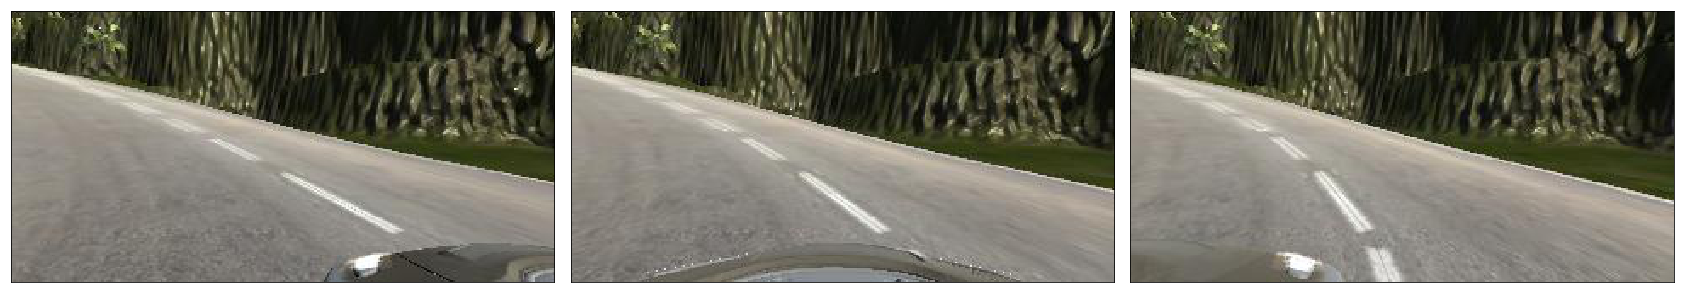

(160, 320, 3)


In [11]:
m = np.random.randint(0,len(samples))
print('training example m :', m)

sample = samples[m]
center_image = cv2.imread(dataLocation + '/IMG/'+sample[0].split(directorySplitter)[-1])
left_image = cv2.imread(dataLocation + '/IMG/'+sample[1].split(directorySplitter)[-1])
right_image = cv2.imread(dataLocation + '/IMG/'+sample[2].split(directorySplitter)[-1])

center_angle = float(sample[3])
left_angle = center_angle + correction
right_angle = center_angle - correction

plt.figure

fig, axes = plt.subplots(1,3, figsize=(30, 5))
fig.subplots_adjust(hspace=0.0, wspace=0.01)

images=[cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB),
        cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB),
        cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)]

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

print(center_image.shape)

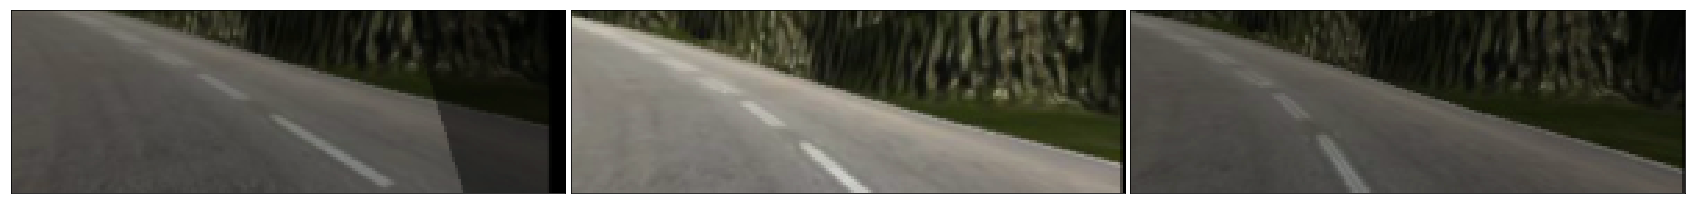

(66, 200, 3)


In [12]:
center_image = augment_brightness_camera_images(center_image)
center_image, center_angle = trans_image(center_image, center_angle, trans_range)
center_image = add_random_shadow(center_image)

left_image = augment_brightness_camera_images(left_image)
left_image, left_angle = trans_image(left_image, left_angle, trans_range)
left_image = add_random_shadow(left_image)

right_image = augment_brightness_camera_images(right_image)
right_image, right_angle = trans_image(right_image, right_angle, trans_range)
right_image = add_random_shadow(right_image)

center_image = image_preprocessing(center_image)
left_image = image_preprocessing(left_image)
right_image = image_preprocessing(right_image)

fig, axes = plt.subplots(1,3, figsize=(30, 5))
fig.subplots_adjust(hspace=0.0, wspace=0.01)

images=[cv2.cvtColor(left_image, cv2.COLOR_YUV2RGB),
        cv2.cvtColor(center_image, cv2.COLOR_YUV2RGB),
        cv2.cvtColor(right_image, cv2.COLOR_YUV2RGB)]

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

print(center_image.shape)

## Generators

In [13]:
def generator_training(samples, batch_size=32):
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                center_image = cv2.imread(dataLocation + '/IMG/'+batch_sample[0].split(directorySplitter)[-1])
                left_image = cv2.imread(dataLocation + '/IMG/'+batch_sample[1].split(directorySplitter)[-1])
                right_image = cv2.imread(dataLocation + '/IMG/'+batch_sample[2].split(directorySplitter)[-1])
                
                center_angle = float(batch_sample[3])
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                # Randomly flips the images to help create even amount of left turns and right turns
                if np.random.rand() > .5:
                    center_image = cv2.flip(center_image, 1)
                    left_image = cv2.flip(left_image, 1)
                    right_image = cv2.flip(right_image, 1)
                    center_angle *= -1
                    left_angle *= -1
                    right_angle *= -1
                
                # Apply augmentation
                center_image = augment_brightness_camera_images(center_image)
                center_image, center_angle = trans_image(center_image, center_angle, trans_range)
                center_image = add_random_shadow(center_image)

                left_image = augment_brightness_camera_images(left_image)
                left_image, left_angle = trans_image(left_image, left_angle, trans_range)
                left_image = add_random_shadow(left_image)

                right_image = augment_brightness_camera_images(right_image)
                right_image, right_angle = trans_image(right_image, right_angle, trans_range)
                right_image = add_random_shadow(right_image)
                
                images.append(image_preprocessing(center_image))
                images.append(image_preprocessing(left_image))
                images.append(image_preprocessing(right_image))

                angles.append(center_angle)
                angles.append(left_angle)
                angles.append(right_angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [14]:
def generator_validation(samples, batch_size=32):
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                center_image = cv2.imread(dataLocation + '/IMG/'+batch_sample[0].split(directorySplitter)[-1])
                left_image = cv2.imread(dataLocation + '/IMG/'+batch_sample[1].split(directorySplitter)[-1])
                right_image = cv2.imread(dataLocation + '/IMG/'+batch_sample[2].split(directorySplitter)[-1])
                
                center_angle = float(batch_sample[3])
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                images.append(image_preprocessing(center_image))
                images.append(image_preprocessing(left_image))
                images.append(image_preprocessing(right_image))
                
                angles.append(center_angle)
                angles.append(left_angle)
                angles.append(right_angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [15]:
# compile and train the model using the generator function
train_generator = generator_training(train_samples, batch_size = 256)
validation_generator = generator_validation(validation_samples, batch_size = 256)

## Model Architecture

In [16]:
def nvidia_model():   
    model = Sequential()
    
    model.add(Lambda(lambda x: x/127.5 - 1.0, input_shape = (66,200,3)))
    
    model.add(Convolution2D(24, 5, 5, subsample = (2, 2), border_mode = "valid", activation = 'elu'))
    model.add(Convolution2D(36, 5, 5, subsample = (2, 2), border_mode = "valid", activation = 'elu'))
    model.add(Convolution2D(48, 5, 5, subsample = (2, 2), border_mode = "valid", activation = 'elu'))
    model.add(Convolution2D(64, 3, 3, subsample = (1, 1), border_mode = "valid", activation = 'elu'))
    model.add(Convolution2D(64, 3, 3, subsample = (1, 1), border_mode = "valid", activation = 'elu'))
    
    model.add(Flatten())
    
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(50, activation = 'elu'))
    model.add(Dense(10, activation = 'elu'))
    model.add(Dense(1, activation = 'elu'))
    
    model.summary()
    
    return model

In [17]:
# For creating a new model
#model = nvidia_model()

# Load the pretrained model to train on another data set
model = load_model('model.h5')

## Training the Model

In [18]:
model_path = os.path.expanduser('model.h5')
save_best = callbacks.ModelCheckpoint(model_path, 
                                      monitor = 'val_loss', 
                                      verbose = 1, 
                                      save_best_only = True, 
                                      mode = 'min')
early_stop = callbacks.EarlyStopping(monitor = 'val_loss', 
                                     min_delta = 0.001, 
                                     patience = 3, 
                                     verbose = 0, 
                                     mode = 'auto')
callbacks_list = [early_stop, save_best]

model.compile(loss = 'mse', optimizer = 'adam')
history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch = len(train_samples)*3, # 3 images per frame
                                     validation_data = validation_generator,
                                     nb_val_samples = len(validation_samples)*3, # 3 images per frame
                                     nb_epoch = 15,
                                     callbacks = callbacks_list)

Epoch 1/15
13116/13116 [==============================] - 90s - loss: 0.2827 - val_loss: 0.2154
Epoch 2/15
13116/13116 [==============================] - 81s - loss: 0.2241 - val_loss: 0.2363
Epoch 3/15
13116/13116 [==============================] - 83s - loss: 0.2129 - val_loss: 0.1740
Epoch 4/15
13116/13116 [==============================] - 83s - loss: 0.2075 - val_loss: 0.1864
Epoch 5/15
13116/13116 [==============================] - 83s - loss: 0.2022 - val_loss: 0.2098
Epoch 6/15
13116/13116 [==============================] - 81s - loss: 0.1967 - val_loss: 0.2165
Epoch 7/15
13116/13116 [==============================] - 82s - loss: 0.1897 - val_loss: 0.1707
Epoch 8/15
13116/13116 [==============================] - 82s - loss: 0.1947 - val_loss: 0.1681
Epoch 9/15
13116/13116 [==============================] - 82s - loss: 0.1851 - val_loss: 0.1575
Epoch 10/15
13116/13116 [==============================] - 82s - loss: 0.1812 - val_loss: 0.1683
Epoch 11/15
13116/13116 [==============

## Visualize losses

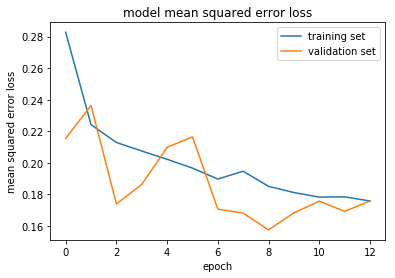

In [19]:
# plot the training and validation loss for each epoch
plt.figure
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()